### Import & load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

--2022-09-27 06:38:34--  https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598 (1.6K) [text/csv]
Saving to: ‘perrin-freres-monthly-champagne.csv’

perrin-freres-month 100%[===================>]   1.56K  --.-KB/s    in 0s      

2022-09-27 06:38:35 (19.5 MB/s) - ‘perrin-freres-monthly-champagne.csv’ saved [1598/1598]



In [3]:
!head perrin-freres-monthly-champagne.csv

Month,Perrin Freres monthly champagne sales millions ?64-?72
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946
1964-06,3036
1964-07,2282
1964-08,2212
1964-09,2922


In [4]:
!tail perrin-freres-monthly-champagne.csv

1972-02,3564
1972-03,4577
1972-04,4788
1972-05,4618
1972-06,5312
1972-07,4298
1972-08,1413
1972-09,5877
,
Perrin Freres monthly champagne sales millions ?64-?72,


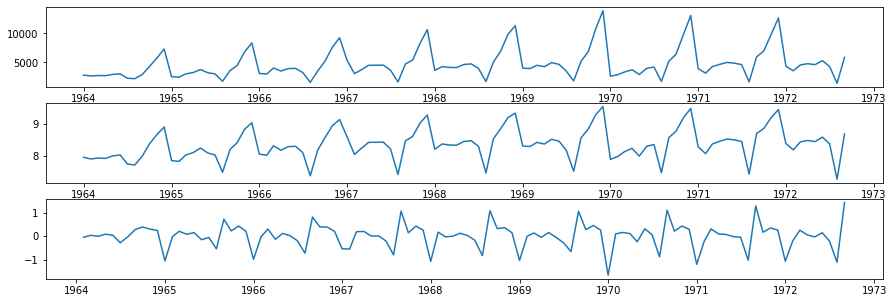

In [5]:
df = pd.read_csv('perrin-freres-monthly-champagne.csv',
                 names=['Month', 'Sales'], header = 0,
                 index_col='Month', parse_dates=True,
                 engine='python', skipfooter=2)
fig, ax = plt.subplots(nrows=3, figsize=(15,5));
ax[0].plot(df);
ax[1].plot(df.apply(np.log));
ax[2].plot(df.apply(np.log).diff());

### Linear regression example

We fit two different models:

1.   Single-output model: predict next month based on past 12 months
2.   Multi-output model: predict next 12 months based on past 12 months

We then compare a multi-step forecast (done with the single-output model by using past predictions as input), with a multi-output forecast from the multi-output model. We try to forecast the last 12 months, based on the previous 12 months.

Note that a naive scoring for the single-output model would be on the one-step forecast, that simply predicts one month ahead. This is only interesting if we really just want to predict one step ahead with our model. It would then make no sense to compare this model with the multi-output one.

In [6]:
from numpy.lib.stride_tricks import sliding_window_view

# We consider log sales
series = df.to_numpy().reshape(-1)

# Define period length T and create sliding windows
T = 12  # 12 months
sliding_series = sliding_window_view(series, T)

# Autoregression: define X and Y from data, all of lenght T.
# Note that Y[i] = X[i+T]. They must not overlap!
X = sliding_series[:-T]
Y = sliding_series[T:]
# print(f'X.shape={X.shape}, Y.shape={Y.shape}')

# We keep the last period for test.
# To achieve complete separation of train and test, we need to remove the last
# T sliding windows from the train set, since they all have data in common
# with the test set.
X_train, X_test, Y_train, Y_test = X[:-T], X[-1:], Y[:-T], Y[-1:]
y_train, y_test = Y_train[:,0], Y_test[:, 0]  # y for the single-output model

In [7]:
# Single-output model
model_s = LinearRegression()
model_s.fit(X_train, y_train)
# One could test the single-output model on single-step predictions, but
# it does not reveal much on its predictive power with respect to the multioutput model.
#print(f'train score (s): {model_s.score(X_train, y_train):.4f}')
#print(f'train mape (s): {mean_absolute_percentage_error(model_s.predict(X_train), y_train):.4f}')

# Multi-output model
model_m = LinearRegression()
model_m.fit(X_train, Y_train)
#print(f'train score (m): {model_m.score(X_train, Y_train):.4f}')
#print(f'train mape (m): {mean_absolute_percentage_error(model_m.predict(X_train), Y_train):.4f}')

# Multi-step forecast
X_ = X_test
Y_s = []
for t in range(T):
  y_ = model_s.predict(X_)[0]
  Y_s.append(y_)
  X_ = np.roll(X_, -1)
  X_[0,-1] = y_
Y_s = np.array(Y_s).T.reshape(-1)

# Multi-output forecast
Y_m = model_m.predict(X_test).reshape(-1)

R2 multi-step  : 0.951
R2 multi-output: 0.978
mape multi-step  : 0.126
mape multi-output: 0.072



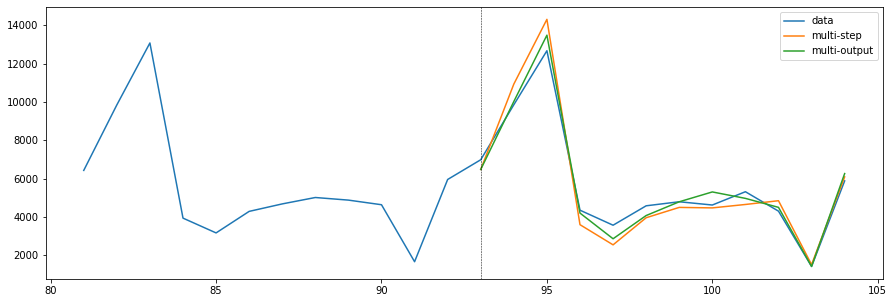

In [8]:
# Compare forecasts from the two models. For the single-output model, we need to 
# calculate the metrics on the multi-step forecast.
Y_test = Y_test.reshape(-1)
print(f'R2 multi-step  : {r2_score(Y_s, Y_test):.3f}')
print(f'R2 multi-output: {r2_score(Y_m, Y_test):.3f}')
print(f'mape multi-step  : {mean_absolute_percentage_error(Y_s, Y_test):.3f}')
print(f'mape multi-output: {mean_absolute_percentage_error(Y_m, Y_test):.3f}')
print()

# Plot data and forecasts
fig, ax = plt.subplots(figsize=(15,5))
N = len(series)
start = N - 2*T  # plot last two periods only
#ax.plot(list(range(start,N-T+1)), series[start:N-T+1], label='train');
#ax.plot(list(range(start+T,N)), Y_test, label='test');
ax.plot(list(range(start,N)), series[start:], label='data');
ax.plot(list(range(start+T,N)), Y_s, label='multi-step');
ax.plot(list(range(start+T,N)), Y_m, label='multi-output');
ax.axvline(x=N-T, color='black', ls='--', lw=.5);
ax.legend();

### Stationarity test

From the ADF test alone, it seems that it would make sense to take the first differences, since the dataset is much more stationary.

In [9]:
from statsmodels.tsa.stattools import adfuller

print(f'ADF(df): {adfuller(df)[1]:.4f}')
print(f'ADF(np.log(df)): {adfuller(np.log(df))[1]:.4f}')
print(f'ADF(df.diff()): {adfuller(df.diff().dropna())[1]:.4f}')

ADF(df): 0.3639
ADF(np.log(df)): 0.1869
ADF(df.diff()): 0.0000


### Define plot_forecast()

We fit two different models:

1.   Single-output model: predict next month based on past 12 months
2.   Multi-output model: predict next 12 months based on past 12 months

We then compare a multi-step forecast (done with the single-output model by using past predictions as input), with a multi-output forecast from the multi-output model. We try to forecast the last 12 months, based on the previous 12 months.

Note that a naive scoring for the single-output model would be on the one-step forecast, that simply predicts one month ahead. This is only interesting if we really just want to predict one step ahead with our model. It would then make no sense to compare this model with the multi-output one.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.base import clone, RegressorMixin  # clone to train two models
from sklearn.multioutput import MultiOutputRegressor  # to make SVR multi-output
from sklearn.metrics import mean_absolute_percentage_error, r2_score

_tr_dict = {
    'id': {'direct': lambda x: x, 'inverse': lambda x: x},
    'log': {'direct': np.log, 'inverse': np.exp}
}

def plot_forecast(df:pd.core.frame.DataFrame, model:RegressorMixin, T=12,
                  diff=False, transform='id',
                  ax:Axes=None) -> Axes:
  
  series = df.to_numpy().reshape(-1)
  transform = _tr_dict[transform]

  # Apply transform and diff, then apply a sliding window
  series_trans = transform['direct'](series)
  if diff:
    series_diff = np.diff(series_trans)
    series_slide = sliding_window_view(series_diff, T)
  else:
    series_slide = sliding_window_view(series_trans, T)

  # Autoregression: define X and Y from data, all of lenght T.
  # Note that Y[i] = X[i+T]. They must not overlap!
  X = series_slide[:-T]
  Y = series_slide[T:]

  # We keep the last period for test.
  # To achieve complete separation of train and test, we need to remove the last
  # T sliding windows from the train set, since they all have data in common
  # with the test set.
  X_train, X_test, Y_train, Y_test = X[:-T], X[-1:], Y[:-T], Y[-1:]
  y_train, y_test = Y_train[:,0], Y_test[:, 0] # y for the single-output model

  # Single-output model
  model_s = clone(model)
  model_s.fit(X_train, y_train)
  # One could test the single-output model on single-step predictions, but
  # it does not reveal much on its predictive power with respect to the multi-output model.
  #print(f'train score (s): {model_s.score(X_train, y_train):.4f}')
  #print(f'train mape (s): {mean_absolute_percentage_error(model_s.predict(X_train), y_train):.4f}')

  # Multi-output model
  model_m = clone(model)
  try:
    model_m.fit(X_train, Y_train)
  except ValueError as e:
    model_m = MultiOutputRegressor(model_m)
    model_m.fit(X_train, Y_train)
  # We prefer to test the model on the actual prediction that we need,
  # after undoing any transform and diff.
  #print(f'train score (m): {model_m.score(X_train, Y_train):.4f}')
  #print(f'train mape (m): {mean_absolute_percentage_error(model_m.predict(X_train), Y_train):.4f}')

  # Multi-step forecast
  X_ = X_test
  Y_s = []
  for t in range(T):
    y_ = model_s.predict(X_)[0]
    Y_s.append(y_)
    X_ = np.roll(X_, -1)
    X_[0,-1] = y_
  Y_s = np.array(Y_s).T.reshape(-1)

  # Multi-output forecast
  Y_m = model_m.predict(X_test).reshape(-1)
  
  # Test data
  Y_test = Y_test.reshape(-1)

  # Undo diff
  if diff:
    x_0 = series_trans[[len(X)+T-1]]  # last train data before differencing
    Y_s = x_0 + np.cumsum(Y_s)
    Y_m = x_0 + np.cumsum(Y_m)
    Y_test = x_0 + np.cumsum(Y_test)
  # Undo transform
  Y_s = transform['inverse'](Y_s)
  Y_m = transform['inverse'](Y_m)
  Y_test = transform['inverse'](Y_test)

  # Compare forecasts from the two models. For the single-output model, we need to 
  # calculate the metrics on the multi-step forecast.
  print(f'R2 multi-step  : {r2_score(Y_s, Y_test):.3f}')
  print(f'R2 multi-output: {r2_score(Y_m, Y_test):.3f}')
  print(f'mape multi-step  : {mean_absolute_percentage_error(Y_s, Y_test):.3f}')
  print(f'mape multi-output: {mean_absolute_percentage_error(Y_m, Y_test):.3f}')
  print()

  # Plot data and forecasts
  if not ax: fig, ax = plt.subplots(figsize=(15,5))
  N = len(series)
  start = N - 2*T  # plot last two periods only
  #ax.plot(list(range(start,N-T+1)), series[start:N-T+1], label='train');
  #ax.plot(list(range(start+T,N)), Y_test, label='test');
  ax.plot(list(range(start,N)), series[start:], label='data')
  ax.plot(list(range(start+T,N)), Y_s, label='multi-step')
  ax.plot(list(range(start+T,N)), Y_m, label='multi-output')
  ax.axvline(x=N-T, color='black', ls='--', lw=.5)
  ax.legend()
  return ax

### Linear regression

R2 multi-step  : 0.951
R2 multi-output: 0.978
mape multi-step  : 0.126
mape multi-output: 0.072

R2 multi-step  : 0.949
R2 multi-output: 0.966
mape multi-step  : 0.099
mape multi-output: 0.082

R2 multi-step  : 0.975
R2 multi-output: 0.976
mape multi-step  : 0.079
mape multi-output: 0.080

R2 multi-step  : 0.961
R2 multi-output: 0.959
mape multi-step  : 0.082
mape multi-output: 0.083



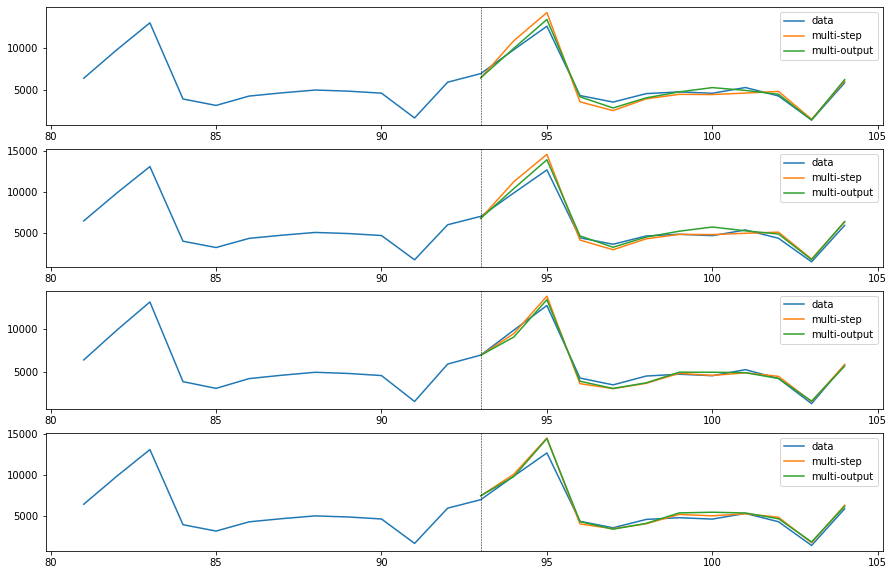

In [13]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(nrows=4, figsize=(15,10))
plot_forecast(df, LinearRegression(), ax=ax[0]);
plot_forecast(df, LinearRegression(), ax=ax[1], diff=True);
plot_forecast(df, LinearRegression(), ax=ax[2], transform='log');  # best one
plot_forecast(df, LinearRegression(), ax=ax[3], transform='log', diff=True);

### SVR with linear kernel

SVR with a linear kernel performs better than with 'rbf' kernel.

R2 multi-step  : 0.878
R2 multi-output: 0.911
mape multi-step  : 0.156
mape multi-output: 0.112

R2 multi-step  : 0.878
R2 multi-output: 0.809
mape multi-step  : 0.515
mape multi-output: 0.696

R2 multi-step  : 0.950
R2 multi-output: 0.943
mape multi-step  : 0.097
mape multi-output: 0.092

R2 multi-step  : 0.958
R2 multi-output: 0.971
mape multi-step  : 0.082
mape multi-output: 0.076



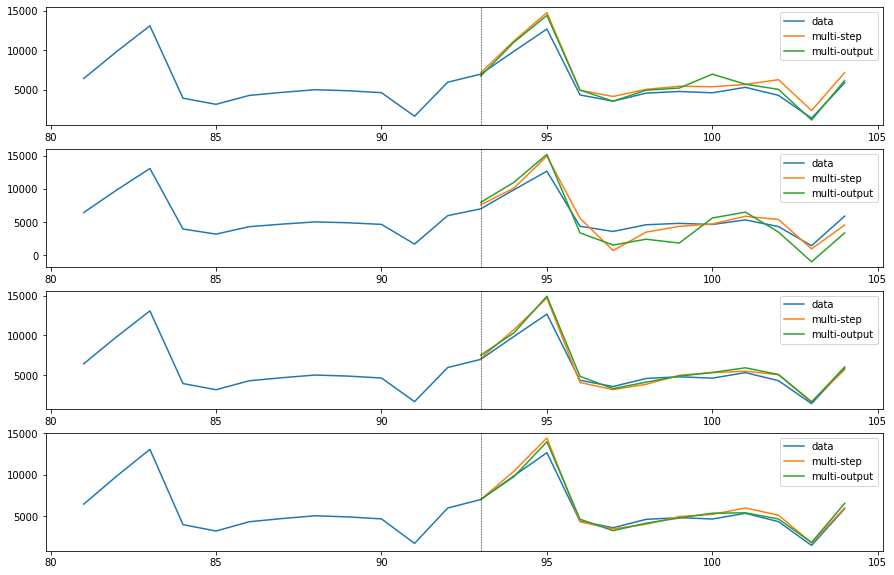

In [15]:
from sklearn.svm import LinearSVR

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)  # we hide the liblinear convergence warnings

fig, ax = plt.subplots(nrows=4, figsize=(15,10))
plot_forecast(df, LinearSVR(max_iter=10000), ax=ax[0]);
plot_forecast(df, LinearSVR(max_iter=10000), ax=ax[1], diff=True);
plot_forecast(df, LinearSVR(max_iter=10000), ax=ax[2], transform='log');
plot_forecast(df, LinearSVR(max_iter=10000), ax=ax[3], diff=True, transform='log');  # best one

### SVR with rbf kernel

Interestingly, SVR with the standard 'rbf' kernel performs poorly if we don't take the log.

R2 multi-step  : -1477510.674
R2 multi-output: -1089.851
mape multi-step  : 0.538
mape multi-output: 0.498

R2 multi-step  : -11.932
R2 multi-output: -11.345
mape multi-step  : 0.497
mape multi-output: 0.502

R2 multi-step  : 0.905
R2 multi-output: 0.943
mape multi-step  : 0.126
mape multi-output: 0.130

R2 multi-step  : 0.765
R2 multi-output: 0.963
mape multi-step  : 0.222
mape multi-output: 0.076



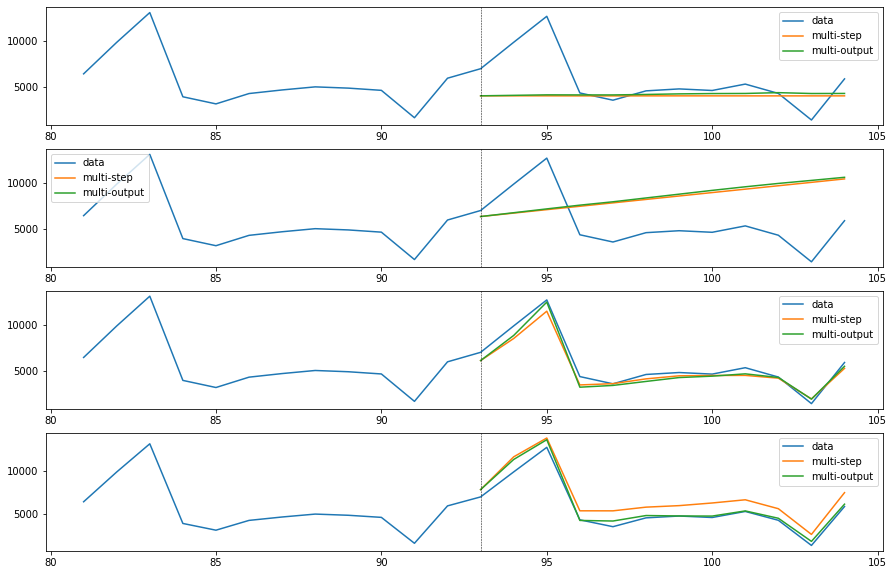

In [16]:
from sklearn.svm import SVR

fig, ax = plt.subplots(nrows=4, figsize=(15,10))
plot_forecast(df, SVR(), ax=ax[0]);  # poor performance without log
plot_forecast(df, SVR(), ax=ax[1], diff=True);  # poor performance without log
plot_forecast(df, SVR(), ax=ax[2], transform='log');  # best multi-step
plot_forecast(df, SVR(), ax=ax[3], transform='log', diff=True);  # best multi-output

### Random Forest

Random Forest performs better with the original dataset.

R2 multi-step  : 0.965
R2 multi-output: 0.917
mape multi-step  : 0.102
mape multi-output: 0.125

R2 multi-step  : 0.946
R2 multi-output: 0.840
mape multi-step  : 0.117
mape multi-output: 0.157

R2 multi-step  : 0.946
R2 multi-output: 0.788
mape multi-step  : 0.112
mape multi-output: 0.172

R2 multi-step  : 0.842
R2 multi-output: 0.796
mape multi-step  : 0.193
mape multi-output: 0.205



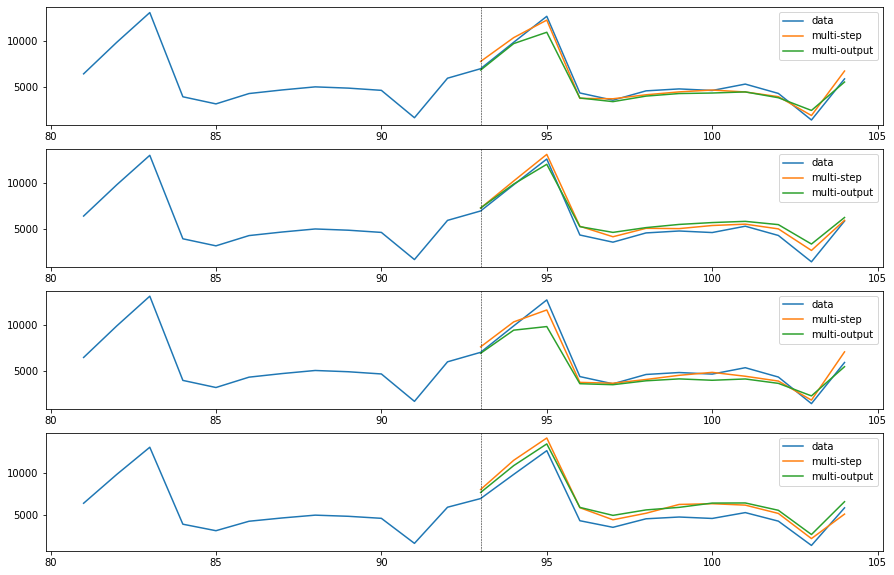

In [17]:
from sklearn.ensemble import RandomForestRegressor

fig, ax = plt.subplots(nrows=4, figsize=(15,10))
plot_forecast(df, RandomForestRegressor(), ax=ax[0]);  # best one
plot_forecast(df, RandomForestRegressor(), ax=ax[1], diff=True);
plot_forecast(df, RandomForestRegressor(), ax=ax[2], transform='log');
plot_forecast(df, RandomForestRegressor(), ax=ax[3], transform='log', diff=True);